### Load dependencies


In [ ]:
%pip install -q -r requirements.txt

### Load environment variables


In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

### Set up vector store


In [2]:
import json
from langchain_openai import AzureOpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document

embeddings = AzureOpenAIEmbeddings(
    api_key=os.environ["OPENAI_API_KEY"],
    azure_endpoint=os.environ["OPENAI_API_ENDPOINT"],
    deployment=os.environ["OPENAI_API_EMBEDDINGS_DEPLOYMENT"],
)

with open("./data/work_orders.json", "r") as f:
    work_orders = json.load(f)

documents = [Document(page_content=json.dumps(wo)) for wo in work_orders]

db = FAISS.from_documents(documents, embeddings)

### Import shared dependencies


In [3]:
from langchain.tools import tool
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional

### Create query tools


In [4]:
class WorkOrderSearch(BaseModel):
    issue: str = Field(
        ...,
        description="Issue reported by the maintenance tech to search work orders. For example, air entrapment or incomplete curing",
    )
    temporal: str = Field(
        ...,
        description="Temporal string that refers to the first or last `n` work orders. Options can be 'first', 'last' or 'all'",
    )
    n: Optional[int] = Field(..., description="Number of work orders requested")


@tool(args_schema=WorkOrderSearch)
def search_work_orders(issue: str, temporal: str, n: Optional[int] = 3) -> List:
    """Search for work orders where a similar issue was observed and/or resolved."""

    embedding = embeddings.embed_query(issue)
    results = db.similarity_search_with_score_by_vector(embedding, n)
    result_documents = [json.loads(result[0].page_content) for result in results]

    if temporal == "last":
        result_documents = sorted(
            result_documents, key=lambda doc: doc["date"], reverse=True
        )
    elif temporal == "first":
        result_documents = sorted(
            result_documents, key=lambda doc: doc["date"], reverse=False
        )

    return result_documents

In [5]:
import pandas as pd
from pandasql import sqldf

parts = pd.read_json("./data/parts.json")


class PartsSearch(BaseModel):
    partName: Optional[str] = Field(
        ..., description="Name or description of the part and is a word or phrase"
    )
    partNumber: Optional[str] = Field(
        ..., description="Part number or ID. This is in the format `XX-00000`"
    )


@tool(args_schema=PartsSearch)
def search_parts(partName: Optional[str], partNumber: Optional[str]) -> List:
    """Search for a part, including its current inventory and location."""

    df = parts

    if partNumber is not None:
        return sqldf(f"SELECT * FROM df WHERE partNumber = '{partNumber}'", locals())
    elif partName is not None:
        return sqldf(f"SELECT * FROM df WHERE partName = '{partName}'", locals())
    else:
        return []

### Create model with tools


In [6]:
from typing import Literal
from langgraph.graph import MessagesState
from langchain_openai import AzureChatOpenAI

tools = [search_parts, search_work_orders]
model = AzureChatOpenAI(
    api_key=os.environ["OPENAI_API_KEY"],
    api_version="2024-02-01",
    azure_deployment=os.environ["OPENAI_API_DEPLOYMENT"],
    azure_endpoint=os.environ["OPENAI_API_ENDPOINT"],
    streaming=True,
    temperature=0,
    verbose=False,
).bind_tools(tools)


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

### Define app from graph


In [7]:
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MessagesState)

tool_node = ToolNode(tools)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### Visually express graph structure


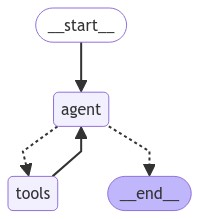

In [8]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### Run app


In [9]:
from langchain_core.messages import HumanMessage


# run this to view each message
def run_agent_debug(query: str, thread_id: str):
    for chunk in app.stream(
        {"messages": [HumanMessage(content=query)]},
        config={"configurable": {"thread_id": thread_id}},
        stream_mode="values",
    ):
        chunk["messages"][-1].pretty_print()


# run this to only get the final streamed response
async def run_agent(query: str, thread_id: str):
    async for event in app.astream_events(
        {"messages": [HumanMessage(content=query)]},
        config={"configurable": {"thread_id": thread_id}},
        stream_mode="values",
        version="v2",
    ):
        kind = event["event"]
        if kind == "on_chat_model_stream":
            content = event["data"]["chunk"].content
            if content:
                # Empty content in the context of OpenAI means
                # that the model is asking for a tool to be invoked.
                # So we only print non-empty content
                print(content, end="")

In [10]:
run_agent_debug(
    "What are the last 2 work orders that show excessive mold wear? Which parts were replaced, and what are their current inventory levels?",
    "7",
)

================================ Human Message =================================

What are the last 2 work orders that show excessive mold wear? Which parts were replaced, and what are their current inventory levels?
================================== Ai Message ==================================
Tool Calls:
  search_work_orders (call_jKz41yaEf3KcF1Fvp2xzrxVk)
 Call ID: call_jKz41yaEf3KcF1Fvp2xzrxVk
  Args:
    issue: excessive mold wear
    temporal: last
    n: 2
================================= Tool Message =================================
Name: search_work_orders

[{"issue": "Excessive mold wear", "solution": "Use high-quality mold materials and coatings. Regularly inspect and maintain the mold. Implement a preventive maintenance schedule to extend mold life.", "date": "2024-01-27", "id": "ISSUE-1017", "replacedParts": ["HE-12345", "CP-44556"]}, {"issue": "Mold surface damage", "solution": "Regularly inspect and repair any damage to the mold surface. Use protective coatings to pr